In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Step curve on ACE2 task: SGPT-RL vs Reinvent

In [2]:
sgpt_step_n = pd.read_csv('data/ace2/sgpt_1000_step_data.csv', index_col=0)
reinvent_step_n = pd.read_csv('data/ace2/reinvent_1000_step_data.csv', index_col=0)

## Validity & docking score

In [3]:
def plot_step_valid_curve(ax, prop, ylabel=None):
    
    df_r = reinvent_step_n[['step', prop]].groupby('step').mean()
    ax.plot(df_r.index.values, df_r[prop].values, label="Reinvent")
    
    df_s = sgpt_step_n[['step', prop]].groupby('step').mean()
    ax.plot(df_s.index.values, df_s[prop].values, label="SGPT-RL")

    ax.set_xlabel('Step')
    ax.set_ylabel(ylabel)
    ax.legend(loc='lower right')

def plot_step_curve(ax, prop, ylabel=None, yrefs=[], step_lim=1000):
    df_r = reinvent_step_n[(reinvent_step_n.Validity == True) & (reinvent_step_n.step <=step_lim)][['step', prop]].groupby('step').mean()
    ax.plot(df_r.index.values, df_r[prop].values, label="Reinvent")
    
    df_s = sgpt_step_n[(sgpt_step_n.Validity == True) & (sgpt_step_n.step <=step_lim)][['step', prop]].groupby('step').mean()
    ax.plot(df_s.index.values, df_s[prop].values, label="SGPT-RL")
    
    ax.set_xlabel('Step')
    ax.set_ylabel(ylabel)
    ax.legend()
    return df_r[prop].values - df_s[prop].values

## New scaffolds

In [4]:
def get_step_new_scaffolds(df_step_n):
    step_scaffold = df_step_n[['scaffold', 'step']].drop_duplicates().groupby('step')['scaffold'].agg(lambda x: set(x))

    prev_scaffods = set()
    steps = []
    step_new_scaffolds = []
    step_num_new_scaffolds = []
    step_cumu_new_scaffolds = []

    for step, scaffolds in step_scaffold.items():
    #     print(step, scaffolds)
        new_scaffolds = scaffolds - prev_scaffods
        steps.append(step)
        step_new_scaffolds.append(new_scaffolds)
        step_num_new_scaffolds.append(len(new_scaffolds))

        prev_scaffods.update(new_scaffolds)
        step_cumu_new_scaffolds.append(len(prev_scaffods))

    df_step_new_scaffold = pd.DataFrame({'step': steps, 'new_scaffolds': step_new_scaffolds, 'num_new_scaffolds': step_num_new_scaffolds, 'cumu_new_scaffolds':step_cumu_new_scaffolds})
    return df_step_new_scaffold

def plot_step_new_scaffold_curve(ax, ylabel=None, step_lim=200):
    ylabel = 'Number of scaffolds' if ylabel is None else ylabel
    sgpt_step_n_lim = sgpt_step_n[sgpt_step_n.step <=step_lim]
    reinvent_step_n_lim = reinvent_step_n[reinvent_step_n.step <=step_lim]
    
    df_sgpt_step_new_scaffold = get_step_new_scaffolds(sgpt_step_n_lim)
    df_reinvent_step_new_scaffold = get_step_new_scaffolds(reinvent_step_n_lim)
    
    ax.plot(df_reinvent_step_new_scaffold.step, df_reinvent_step_new_scaffold.cumu_new_scaffolds, label="Reinvent")
    ax.plot(df_sgpt_step_new_scaffold.step, df_sgpt_step_new_scaffold.cumu_new_scaffolds, label="SGPT-RL")
    
    ax.set_xlabel('Step')
    ax.set_ylabel(ylabel)
    ax.legend(loc='lower right')

## Ring count

In [5]:
def plot_step_ring_count_curve(ax, ylabel=None, step_lim=200):
    ylabel = 'Number of rings' if ylabel is None else ylabel
    
    reinvent_step_n_lim = reinvent_step_n[reinvent_step_n.step <=step_lim][['step', 'ring_count']].groupby('step').mean()
    sgpt_step_n_lim = sgpt_step_n[sgpt_step_n.step <=step_lim][['step', 'ring_count']].groupby('step').mean()
    
    ax.plot(reinvent_step_n_lim.index, reinvent_step_n_lim.ring_count, label="Reinvent")
    ax.plot(sgpt_step_n_lim.index, sgpt_step_n_lim.ring_count, label="SGPT-RL")
    
    ax.set_xlabel('Step')
    ax.set_ylabel(ylabel)
    ax.legend(loc='lower right')
    
    return sgpt_step_n_lim.ring_count - reinvent_step_n_lim.ring_count

## Plot figure

(0.8727752123841774, 4.10075667893e-313)


/home/xiaopeng/Desktop/Chem_design/env/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


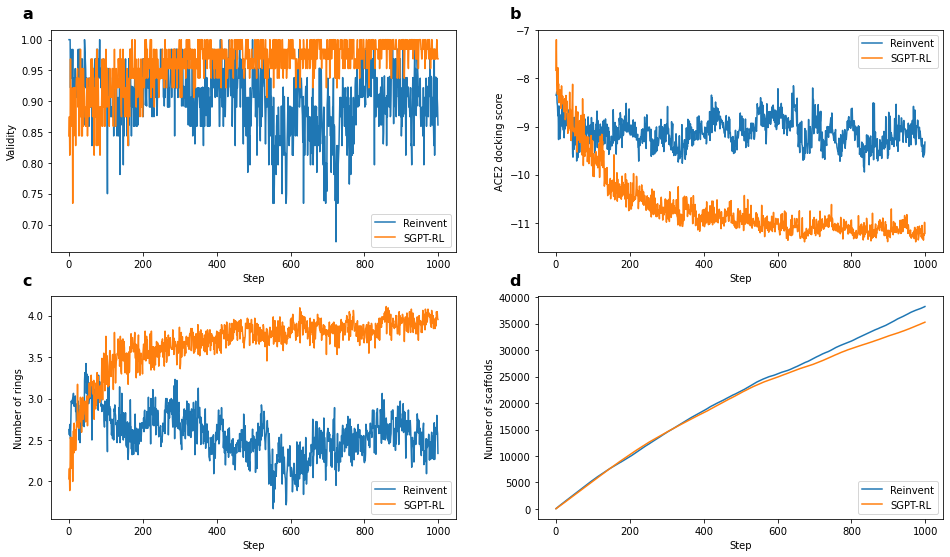

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(16, 9))

plot_step_valid_curve(axs[0,0], 'Validity', ylabel='Validity')
axs[0,0].text(-0.07, 1.05, "a", transform=axs[0,0].transAxes, size=16, weight='bold')

score_diff = plot_step_curve(axs[0,1], 'raw_DockScore', ylabel='ACE2 docking score', step_lim=1000)

axs[0,1].text(-0.07, 1.05, "b", transform=axs[0,1].transAxes, size=16, weight='bold')

n_rings_diff = plot_step_ring_count_curve(axs[1,0], step_lim=1000)
axs[1,0].text(-0.07, 1.05, "c", transform=axs[1,0].transAxes, size=16, weight='bold')


plot_step_new_scaffold_curve(axs[1,1], step_lim=1000)
axs[1,1].text(-0.07, 1.05, "d", transform=axs[1,1].transAxes, size=16, weight='bold')


res = stats.pearsonr(score_diff, n_rings_diff)
print(res)

fig.savefig("figures/ace2_step.pdf", bbox_inches='tight')
fig.show()